In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup

from nltk.sentiment.vader import SentimentIntensityAnalyzer

from urllib.request import urlopen, Request

In [2]:
main_url = "https://finviz.com/quote.ashx?t="

In [3]:
tickers = ['AMZN','TSLA','GOOG']
newstables = {}

In [4]:
## requested access to webpage using Request specifying user-agent
## opened the webpage by urlopen
## use beautifulSoup to parse through the html code of the page
## saved the table of the newsheadlines in a dictionary

In [5]:
for ticker in tickers:
    url = main_url+ticker
    req = Request(url = url,headers = {'user-agent' : 'my-app'})
    resp = urlopen(req)
    html = BeautifulSoup(resp,'html')
    news = html.find(id = 'news-table')
    newstables[ticker] = news

In [6]:
## extracted the headlines, and the time and date from the html code and saved it in a list parsed_data

In [7]:
parsed_data = []
for ticker,newstable in newstables.items():
    rows = newstable.findAll('tr')
    for row in rows:
        headline = row.a.text
        datetime = row.td.text.split(' ')
        
        if(len(datetime)==1):
            time = datetime[0]
            time = time.replace('\xa0\xa0','')
        else:
            date=datetime[0]
            time=datetime[1]
            time = time.replace('\xa0\xa0','')
        
        parsed_data.append([ticker,headline,date,time])

In [8]:
##converting the data with us in the form of list of list to pandas dataframe
## apply sentiment analysis on headlines using nltk.sentiment.vader module

In [9]:
data = pd.DataFrame(parsed_data,columns=['ticker','headlines','date','time'])
data

,ticker,headlines,date,time
0,AMZN,11 Best Depressed Stocks To Invest In,Jan-08-22,09:29AM
1,AMZN,1 EV Stock With More Upside Than Rivian,Jan-08-22,09:03AM
2,AMZN,"Down 19.5% in 2021, Is MercadoLibre a Buy for ...",Jan-08-22,08:25AM
3,AMZN,"If You Own This Stock, It's a Good Time to Sell",Jan-08-22,08:00AM
4,AMZN,4 Reasons Why Sea Limited Is a Great Investment,Jan-08-22,07:22AM
...,...,...,...,...
295,GOOG,Your BlackBerry Dies Today: End of an Era for ...,Jan-04-22,12:37AM
296,GOOG,Want to be Uncle Sam's Landlord? Earn up to 8....,Jan-03-22,07:15PM
297,GOOG,Alphabet (GOOGL) Gains But Lags Market: What Y...,Jan-03-22,05:45PM
298,GOOG,10 Energy Stocks to Buy According to Billionai...,Jan-03-22,05:06PM


In [10]:
sent = SentimentIntensityAnalyzer()
data['compound_score'] = data['headlines'].apply(lambda line: sent.polarity_scores(line)['compound'])

In [11]:
## converting dates from string to datetime

In [12]:
data['date'] = pd.to_datetime(data['date']).dt.date
data

,ticker,headlines,date,time,compound_score
0,AMZN,11 Best Depressed Stocks To Invest In,2022-01-08,09:29AM,0.2263
1,AMZN,1 EV Stock With More Upside Than Rivian,2022-01-08,09:03AM,0.0000
2,AMZN,"Down 19.5% in 2021, Is MercadoLibre a Buy for ...",2022-01-08,08:25AM,0.0000
3,AMZN,"If You Own This Stock, It's a Good Time to Sell",2022-01-08,08:00AM,0.4404
4,AMZN,4 Reasons Why Sea Limited Is a Great Investment,2022-01-08,07:22AM,0.4939
...,...,...,...,...,...
295,GOOG,Your BlackBerry Dies Today: End of an Era for ...,2022-01-04,12:37AM,0.0000
296,GOOG,Want to be Uncle Sam's Landlord? Earn up to 8....,2022-01-03,07:15PM,0.0772
297,GOOG,Alphabet (GOOGL) Gains But Lags Market: What Y...,2022-01-03,05:45PM,-0.3716
298,GOOG,10 Energy Stocks to Buy According to Billionai...,2022-01-03,05:06PM,0.2732


In [13]:
## averaging out the compound score for a day

mean_score = data.groupby(['ticker','date']).mean()
mean_score

compound_score
ticker date                      
AMZN   2022-01-05        0.202706
       2022-01-06        0.173600
       2022-01-07        0.115755
       2022-01-08        0.199400
GOOG   2022-01-03       -0.005300
       2022-01-04        0.165974
       2022-01-05        0.125923
       2022-01-06        0.088910
       2022-01-07        0.091624
TSLA   2022-01-04        0.116900
       2022-01-05        0.062394
       2022-01-06        0.118746
       2022-01-07        0.030156
       2022-01-08        0.022120

In [14]:
## unstacking the data to have dates as x axis
mean_score = mean_score.unstack()

In [15]:
mean_score

compound_score                                                       
date       2022-01-03 2022-01-04 2022-01-05 2022-01-06 2022-01-07 2022-01-08
ticker                                                                      
AMZN              NaN        NaN   0.202706   0.173600   0.115755    0.19940
GOOG          -0.0053   0.165974   0.125923   0.088910   0.091624        NaN
TSLA              NaN   0.116900   0.062394   0.118746   0.030156    0.02212

In [16]:
mean_score = mean_score.xs('compound_score',axis="columns").transpose()

In [17]:
mean_score

ticker,AMZN,GOOG,TSLA
date,,,
2022-01-03,NaN,-0.005300,NaN
2022-01-04,NaN,0.165974,0.116900
2022-01-05,0.202706,0.125923,0.062394
2022-01-06,0.173600,0.088910,0.118746
2022-01-07,0.115755,0.091624,0.030156
2022-01-08,0.199400,NaN,0.022120


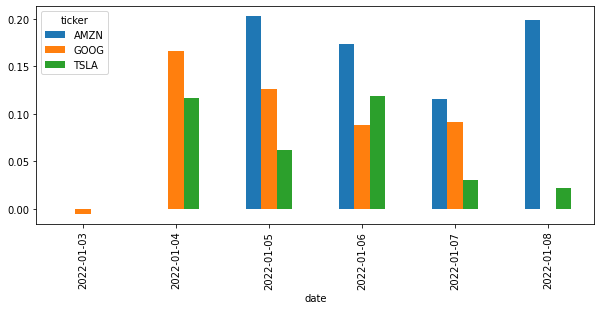

In [20]:
plt.rcParams['figure.figsize'] = [10, 4]
mean_score.plot(kind= "bar")
plt.show()